# District Heating: An Investigation into the Efficiency of a Centralized Heating System
#### Thermodynamics, Final Project  |  Karen Hinh, Mads Young
District heating is a method of home climate control that should be more utilized in the future due to its energy efficiency and friendliness to more sustainable energy sources. For heat sources, there’s geothermal or water source heat pumps, as well as gas or electric boilers, but for the purposes of this project, we are going to focus on exploring the differences between water source heat pumps and gas / electric boilers.

In this project, we will investigate the efficiencies of a small scale district heating network with different heat sources (water source heat pumps and gas / electric boilers) and mediums of heat transfer (liquid water vs steam). If there’s extra time, we would be interested in exploring the efficiency difference between small scale district heating with decentralized heating in houses. 

To accomplish this, we will build a thermodynamic model of a small scale district heating network with variables such as the amount of heat put in, the initial and final (after heat extraction) temperature of the fluid and pressure differences within the heat pump. We will use the model to compare energy cost, thermodynamic properties, and efficiency of the relevant heating methods to ideally prove the superiority of district heating networks over decentralized heating. This will be done in coolprop.

![](final_system_diagram.png)

In [2]:
import CoolProp.CoolProp as CP
import CoolProp.Plots as CPP
import numpy as np
import matplotlib.pyplot as plt

## Assumptions

### Sources 
- Typical pressures for R410a: https://www.achrnews.com/articles/92875-the-essentials-of-working-with-r-410a#:~:text=A%20normally%20operating%20R%2D410A,side%20pressure%20of%20130%20psig.

In [7]:
# based off of heat pump cycle in textbook (assumed water outside is 10 C)

T1 = 2 + 273.15 # K
T2 = 48.88 + 273.15 # K
T3 = 30 + 273.15 # K
T4 = T1

P1 = 896 * 1000 # Pa
P2 = 2882 * 1000 # Pa
P3 = 200 *1000 # Pa
P4 = 700 *1000 # Pa

substance = 'R410a'

# Enthalpy calculations
h1 = CP.PropsSI('H', 'T',T1, 'P',P1, substance) # vapor, J/kg
h2 = CP.PropsSI('H', 'T',T2, 'P',P2, substance) # vapor, J/kg
h3 = CP.PropsSI('H', 'T',T3, 'P',P3, substance) # liquid, J/kg
h4 = 213.2942 * 1000 # vapor-liquid, J/kg

print('The enthalpy at state 1-4 are: \n' 
      + str(round(h1,2)) + ' J/kg, \n' + str(round(h2,2)) + ' J/kg, \n' 
      + str(round(h3,2)) + ' J/kg, \n' + str(round(h4,2)) + ' J/kg. ')

# Other constants
c_water = 4168 # J/kg-C

The enthalpy at state 1-4 are: 
203047.25 J/kg, 
426390.53 J/kg, 
462422.68 J/kg, 
213294.2 J/kg. 


## Base Calculations

In [12]:
m = 38 / 3600 # kg/s
m_water = 0.03 # kg/s

Q41 = m * (h4 - h1) # W
Q23 = m * (h2 - h3) # W
W12 = m * (h1 - h2) # W
COP = Q23 / W12

dT_house = Q41 / (m_water * c_water)

print(str(round(Q41,2)), str(round(Q23,2)), str(round(W12,2)), str(round(COP,2)), str(round(dT_house,2)))

108.16 -380.34 -2357.51 0.16 0.87


# Varied Mass Flow Rate (Heat Pump) and Mass Flow Rate (Water Loop)
### Sources
- Mass flow rate of heat pump: https://www.iosrjournals.org/iosr-jmce/papers/RDME-Volume4/RDME-34.pdf

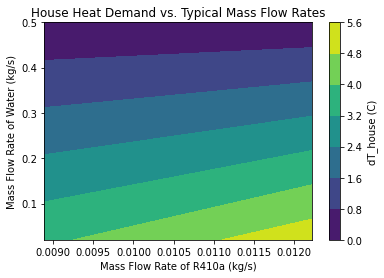

In [76]:
m_water = np.array([0.02,0.5]) # kg/s
m = np.array([32,44]) / 3600 # kg/s

cmesh, tmesh = np.meshgrid(m, m_water)
Hs = np.zeros_like(cmesh)

for i, m in enumerate(m):
    Q23 = m * (h2 - h3) # W
    dT_water = -Q23/(m_water*c_water) # C
    Hs[:,i] = dT_water

plt.figure
plt.contourf(cmesh,tmesh,Hs)
plt.colorbar(label='dT_house (C)')
plt.ylabel('Mass Flow Rate of Water (kg/s)')
plt.xlabel('Mass Flow Rate of R410a (kg/s)')
plt.title('House Heat Demand vs. Typical Mass Flow Rates')
plt.show()

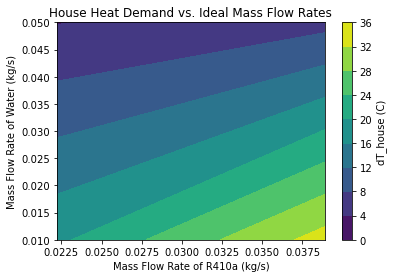

In [77]:
m_water = np.array([0.01,0.05]) # kg/s
m = np.array([80,140]) / 3600 # kg/s

cmesh, tmesh = np.meshgrid(m, m_water)
Hs = np.zeros_like(cmesh)

for i, m in enumerate(m):
    Q23 = m * (h2 - h3) # W
    dT_water = -Q23/(m_water*c_water) # C
    Hs[:,i] = dT_water

plt.figure
plt.contourf(cmesh,tmesh,Hs)
plt.colorbar(label='dT_house (C)')
plt.ylabel('Mass Flow Rate of Water (kg/s)')
plt.xlabel('Mass Flow Rate of R410a (kg/s)')
plt.title('House Heat Demand vs. Ideal Mass Flow Rates')
plt.show()

## Varied Heat Demand from Houses

In [99]:
# House Heat Demand
hot_temp = 70 # C

dT_h1 = np.array([-30, -10]) # C
dT_h2 = np.array([-20, -10]) # C
dT_h3 = np.array([-40, -20]) # C

Th_1 = hot_temp + dT_h1
Th_2 = hot_temp + dT_h2
Th_3 = hot_temp + dT_h3

# Heat Loss
r_pipe = 0.04 # m
h_pipe = 20 # m
k = .005  # W/m*K heat loss coefficient
soiltemp = 35 #C
hl = h_pipe * k * ((hot_temp+273.15) + (Th_1+273.15) - 2*(soiltemp+273.15)) #W, watts lost
heatloss = hl / c_water

v_water = 3.1415 * r_pipe**2 * h_pipe # m3
rho_water = 997 # kg/m3
mass_water = v_water * rho_water

cold_temp = ((mass_water*Th_1 + mass_water*Th_2 + mass_water*Th_3) / (3*mass_water)) - heatloss # C
dT_water =  hot_temp - cold_temp

print(dT_water)

[30.00095969 13.33477287]


In [100]:
m_water = 0.03 # kg/s

Q = m_water * c_water * dT_water

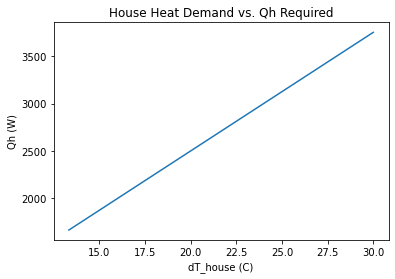

In [101]:
plt.plot(dt_loop, Q)
plt.xlabel("dT_house (C)")
plt.ylabel("Qh (W)")
plt.title("House Heat Demand vs. Qh Required")
plt.show()

## Varied Distance Between Houses

In [102]:
# House Density
dT_house = -20 # C
Th_1 = hot_temp + dT_house

h_pipe = np.array([20, 60]) # m 
hl = h_pipe * k * ((hot_temp+273.15) + (Th_1+273.15) - 2*(soiltemp+273.15)) #W, watts lost
heatloss = hl / c_water

cold_temp = Th_1 - heatloss # C
dT_water =  hot_temp - cold_temp

print(dT_water)

[20.00119962 20.00359885]


In [103]:
Qh = m_water * c_water * dT_water

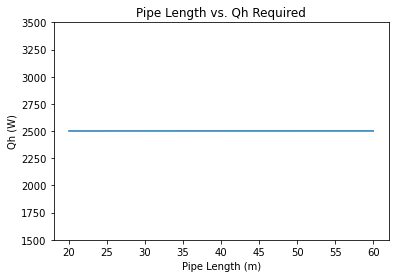

In [98]:
plt.plot(h_pipe, Qh)
plt.xlabel("Pipe Length (m)")
plt.ylabel("Qh (W)")
plt.title("Pipe Length vs. Qh Required")
plt.ylim((1500, 3500)) 
plt.show()